In [6]:
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
import pytensor 

import pymc as pm
import arviz as az
import pyhf
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Using pyhf as external pdf model for pyMC
We build a pyhf model and analyse it with pyMC. 

### Signal, background and bbservation
... defining signal, background and the observation.

In [7]:
### Signal, background and observation
nBins = 20
sig = (10*np.exp(-(np.arange(nBins)-nBins/2)**2/20))
bkg = (100*np.exp(-np.arange(nBins)/20))
db = (bkg*0.1).tolist()
bkg = bkg.tolist()
sig = sig.tolist()

### Setting up the pyhf model
model = pyhf.simplemodels.uncorrelated_background(sig, bkg, db)

### Observations
    ## Determines the actual signal strength
dummyPars = [2]
    ## Setting all gamma_i to ...
[dummyPars.append(1) for i in range(nBins)]

obs = model.expected_actualdata(dummyPars)

### Printing
# print(f"dummyPars: {dummyPars}")
# print(f"Signal: {sig}")
# print(f"Background: {bkg}")
# print(f"Observations: {obs}")

### Defining the Op class
... calling that class creates with the input of a name `name` and a function `func`, in this case the pyhf function `model.expected_actual data`, an object which can work with `pytensor.tensor.var.TensorVariable` as input parameter format. This is needed for the pyMC model.

In [8]:
### Class that creates the model Op
class Op(pt.Op):
    itypes = [pt.dvector]  # expects a vector of parameter values
    otypes = [pt.dvector]  # outputs a vector of values (the model.expected_actualdata)

    def __init__(self, func, name):
        ## add inputs as class attributes
        self.func = func
        self.name = name

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        ## Calling the input function (in our case the model.expected_actualdata)
        result = self.func(theta)

        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

### Creating the pyMC model
... using the pyhf model as pdf for pyMC.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigStr]
>Slice: [gamma0]
>Slice: [gamma1]
>Slice: [gamma2]
>Slice: [gamma3]
>Slice: [gamma4]
>Slice: [gamma5]
>Slice: [gamma6]
>Slice: [gamma7]
>Slice: [gamma8]
>Slice: [gamma9]
>Slice: [gamma10]
>Slice: [gamma11]
>Slice: [gamma12]
>Slice: [gamma13]
>Slice: [gamma14]
>Slice: [gamma15]
>Slice: [gamma16]
>Slice: [gamma17]
>Slice: [gamma18]
>Slice: [gamma19]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Sampling: [gamma0, gamma1, gamma10, gamma11, gamma12, gamma13, gamma14, gamma15, gamma16, gamma17, gamma18, gamma19, gamma2, gamma3, gamma4, gamma5, gamma6, gamma7, gamma8, gamma9, main, sigStr]
Sampling: [main]


array([[<AxesSubplot: title={'center': 'sigStr'}>,
        <AxesSubplot: title={'center': 'sigStr'}>]], dtype=object)

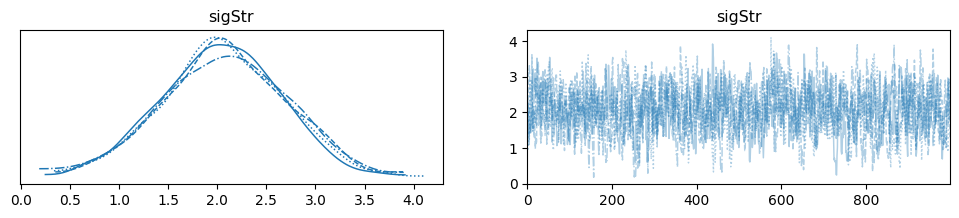

In [12]:
### Appling the Op with arguments (function, name)
mainOp = Op(model.expected_actualdata, "mainOp")

### Opening the pyMC model space F
with pm.Model() as basic_model:
    ## TensorVar input parameters [sigStr, gamma_i, ... ,gamma_nBins]
    pars = [pm.HalfNormal("sigStr", sigma=2)]
    pars.extend(pm.Gamma(f"gamma{idx}", alpha=20, beta=20) for idx in range(nBins))
    pars = pt.as_tensor_variable(pars)

    main = pm.Deterministic("mainDet", mainOp(pars)) 

    pm.Poisson("main", mu=main, observed=obs)

    ## Sampling ...
    post_data = pm.sample()
    prior_data = pm.sample_prior_predictive(samples=N)
    post_pred = pm.sample_posterior_predictive(data)


# ### Priors and Posteriors
# N = 100

# with basic_model:
#     prior_data = pm.sample_prior_predictive(samples=N)
#     post_pred = pm.sample_posterior_predictive(data)

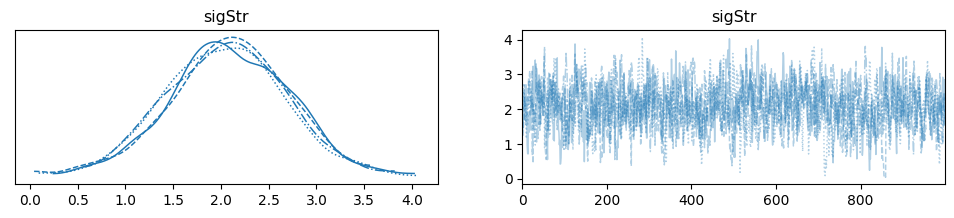

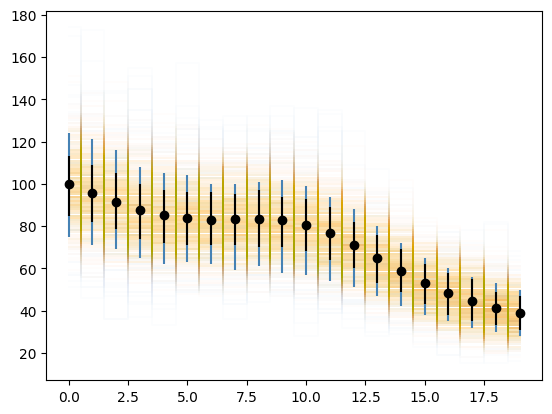

In [17]:
### Trace for the signal strength
az.plot_trace(post_data, var_names=["sigStr"])
plt.show()

### Plotting ...
    ##
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
    ## 
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
    ##
plt.vlines(np.arange(nBins),*np.quantile(prior_idata.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue')
    ## 
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'k')
    ## 
plt.scatter(np.arange(nBins),obs, c = 'k', zorder = 999)